In [60]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score

init_notebook_mode(connected=True)
RANDOM_SEED = 123

# Data Import and Preprocessing

In [8]:
IMG_PATH = 'brain_tumor_dataset/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME) 

In [9]:
def load_data(dir_path, img_size=(100, 100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print('{} images loaded from {} directory.'.format(len(X), dir_path))
    return X, y, labels
    

In [10]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224, 224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.22it/s]
C:\Users\zeyne\anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

  0%|          | 0/2 [00:00<?, ?it/s]

242 images loaded from TRAIN/ directory.
19 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

92 images loaded from VAL/ directory.


In [17]:
def preprocess_imgs(set_name, img_size):
    
    # Resize and apply VGG-15 preprocessing
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [19]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

# CNN Model

## Data Augmentation

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 242 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


## VGG-16

### Model Building 

In [12]:
# loading base model
base_model_vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

58892288/58889256 [==============================] - 5s 0us/step


In [13]:
NUM_CLASSES = 1

model_vgg = Sequential()
model_vgg.add(base_model_vgg)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dropout(0.5))
model_vgg.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_vgg.layers[0].trainable = False

model_vgg.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
EPOCHS = 30

history_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
    )

Epoch 1/30
8/8 [==============================] - 18s 2s/step - loss: 5.3303 - accuracy: 0.5165 - val_loss: 0.4099 - val_accuracy: 0.7174
Epoch 2/30
8/8 [==============================] - 2s 279ms/step - loss: 3.4246 - accuracy: 0.6157 - val_loss: 1.8743 - val_accuracy: 0.8261
Epoch 3/30
8/8 [==============================] - 3s 351ms/step - loss: 3.7456 - accuracy: 0.6240 - val_loss: 2.6186 - val_accuracy: 0.8587
Epoch 4/30
8/8 [==============================] - 3s 345ms/step - loss: 2.9905 - accuracy: 0.6818 - val_loss: 0.8381 - val_accuracy: 0.8696
Epoch 5/30
8/8 [==============================] - 3s 351ms/step - loss: 3.1882 - accuracy: 0.6901 - val_loss: 0.1546 - val_accuracy: 0.9130
Epoch 6/30
8/8 [==============================] - 3s 356ms/step - loss: 2.3901 - accuracy: 0.7190 - val_loss: 0.5545 - val_accuracy: 0.9022
Epoch 7/30
8/8 [==============================] - 3s 357ms/step - loss: 2.4489 - accuracy: 0.6983 - val_loss: 0.0073 - val_accuracy: 0.9239
Epoch 8/30
8/8 [======

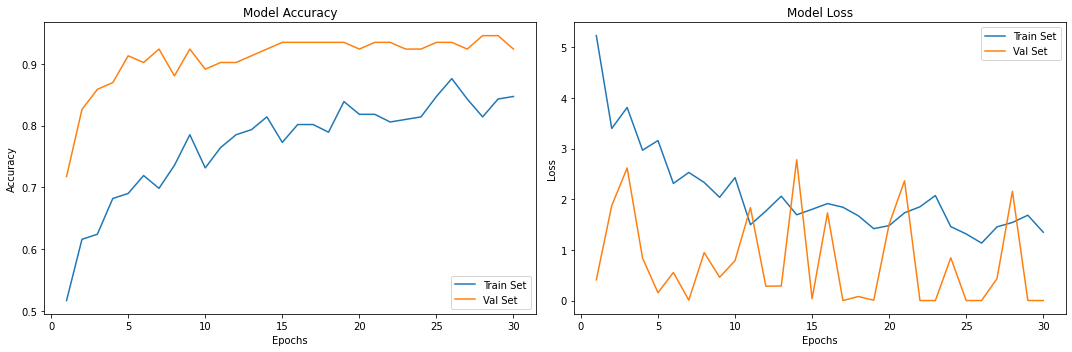

In [15]:
# plot model performance
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs_range = range(1, len(history_vgg.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [68]:
# validate on test set
predictions = model_vgg.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.85
Test Accuracy = 0.95
Val Accuracy = 0.92
Kappa Score = 0.89
ROC Area = 0.94
Precision = 0.95


## DenseNet 201

In [69]:
# load base model
base_model_dense = DenseNet201(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

74842112/74836368 [==============================] - 6s 0us/step


In [70]:
NUM_CLASSES = 1

model_dense = Sequential()
model_dense.add(base_model_dense)
model_dense.add(layers.Flatten())
model_dense.add(layers.Dropout(0.5))
model_dense.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_dense.layers[0].trainable = False

model_dense.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_dense.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 94080)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 94081     
Total params: 18,416,065
Trainable params: 94,081
Non-trainable params: 18,321,984
_________________________________________________________________


In [71]:
history_dense = model_dense.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 35s 4s/step - loss: 0.8837 - accuracy: 0.6488 - val_loss: 1.2820 - val_accuracy: 0.6630
Epoch 2/30
8/8 [==============================] - 4s 483ms/step - loss: 0.6191 - accuracy: 0.7355 - val_loss: 3.5815 - val_accuracy: 0.6196
Epoch 3/30
8/8 [==============================] - 4s 481ms/step - loss: 0.4233 - accuracy: 0.8264 - val_loss: 4.9148 - val_accuracy: 0.6196
Epoch 4/30
8/8 [==============================] - 4s 482ms/step - loss: 0.6303 - accuracy: 0.7231 - val_loss: 2.5974 - val_accuracy: 0.6413
Epoch 5/30
8/8 [==============================] - 4s 482ms/step - loss: 0.4678 - accuracy: 0.7769 - val_loss: 4.8208 - val_accuracy: 0.6196
Epoch 6/30
8/8 [==============================] - 4s 483ms/step - loss: 0.3709 - accuracy: 0.8140 - val_loss: 4.5795 - val_accuracy: 0.6196
Epoch 7/30
8/8 [==============================] - 4s 483ms/step - loss: 0.3889 - accuracy: 0.8306 - val_loss: 14.9563 - val_accuracy: 0.6196
Epoch 8/30
8/8 [=====

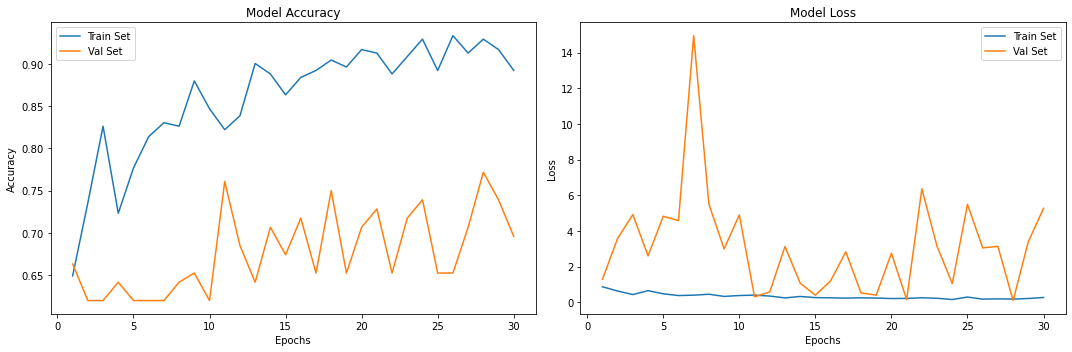

In [72]:
# plot model performance
acc = history_dense.history['accuracy']
val_acc = history_dense.history['val_accuracy']
loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']
epochs_range = range(1, len(history_dense.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [73]:
# validate on test set
predictions = model_dense.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.89
Test Accuracy = 0.58
Val Accuracy = 0.70
Kappa Score = 0.18
ROC Area = 0.59
Precision = 0.55


### InceptionV3

In [74]:
# load base model
base_model_inception = InceptionV3(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

87916544/87910968 [==============================] - 8s 0us/step


In [75]:
NUM_CLASSES = 1

model_inception= Sequential()
model_inception.add(base_model_inception)
model_inception.add(layers.Flatten())
model_inception.add(layers.Dropout(0.5))
model_inception.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_inception.layers[0].trainable = False

model_inception.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_inception.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [76]:
history_inception = model_inception.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 14s 2s/step - loss: 0.7973 - accuracy: 0.6033 - val_loss: 9.5488 - val_accuracy: 0.5652
Epoch 2/30
8/8 [==============================] - 1s 171ms/step - loss: 0.6581 - accuracy: 0.6612 - val_loss: 3.8814 - val_accuracy: 0.5870
Epoch 3/30
8/8 [==============================] - 3s 369ms/step - loss: 0.6533 - accuracy: 0.6901 - val_loss: 9.3681 - val_accuracy: 0.5870
Epoch 4/30
8/8 [==============================] - 3s 358ms/step - loss: 0.6018 - accuracy: 0.7231 - val_loss: 20.4024 - val_accuracy: 0.5978
Epoch 5/30
8/8 [==============================] - 3s 356ms/step - loss: 0.5796 - accuracy: 0.7190 - val_loss: 12.3151 - val_accuracy: 0.6087
Epoch 6/30
8/8 [==============================] - 3s 349ms/step - loss: 0.5209 - accuracy: 0.7686 - val_loss: 11.6438 - val_accuracy: 0.5870
Epoch 7/30
8/8 [==============================] - 3s 354ms/step - loss: 0.5685 - accuracy: 0.7314 - val_loss: 4.8965 - val_accuracy: 0.5761
Epoch 8/30
8/8 [===

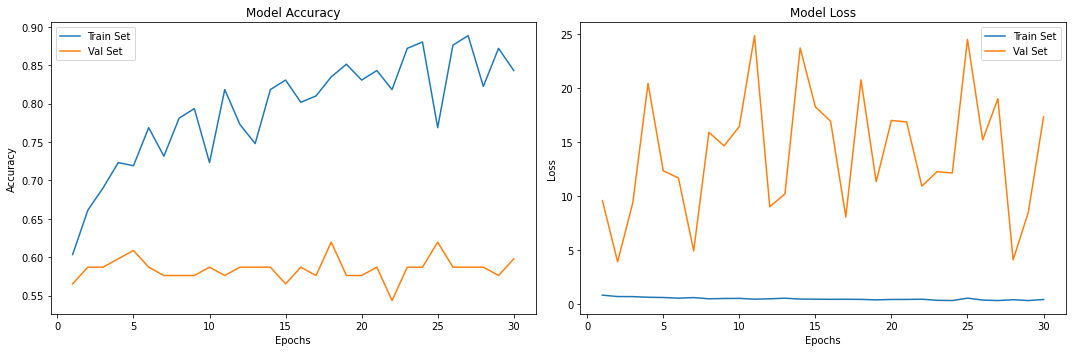

In [77]:
# plot model performance
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs_range = range(1, len(history_inception.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [79]:
# validate on test set
predictions = model_inception.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.84
Test Accuracy = 0.58
Val Accuracy = 0.60
Kappa Score = 0.19
ROC Area = 0.60
F1 Score = 0.51


### Xception

In [80]:
# load base model
base_model_xception = Xception(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

83689472/83683744 [==============================] - 7s 0us/step


In [81]:
NUM_CLASSES = 1

model_xception= Sequential()
model_xception.add(base_model_xception)
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_xception.layers[0].trainable = False

model_xception.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_xception.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 100353    
Total params: 20,961,833
Trainable params: 100,353
Non-trainable params: 20,861,480
_________________________________________________________________


In [82]:
history_xception = model_xception.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 12s 1s/step - loss: 0.6962 - accuracy: 0.6446 - val_loss: 8.1909 - val_accuracy: 0.6196
Epoch 2/30
8/8 [==============================] - 3s 407ms/step - loss: 0.5854 - accuracy: 0.6901 - val_loss: 4.0521 - val_accuracy: 0.6196
Epoch 3/30
8/8 [==============================] - 4s 538ms/step - loss: 0.4647 - accuracy: 0.8140 - val_loss: 5.8971 - val_accuracy: 0.6196
Epoch 4/30
8/8 [==============================] - 4s 512ms/step - loss: 0.5019 - accuracy: 0.7314 - val_loss: 6.2820 - val_accuracy: 0.6196
Epoch 5/30
8/8 [==============================] - 4s 498ms/step - loss: 0.4006 - accuracy: 0.8430 - val_loss: 6.3623 - val_accuracy: 0.6196
Epoch 6/30
8/8 [==============================] - 4s 489ms/step - loss: 0.3559 - accuracy: 0.8471 - val_loss: 4.7647 - val_accuracy: 0.6196
Epoch 7/30
8/8 [==============================] - 4s 554ms/step - loss: 0.3961 - accuracy: 0.8306 - val_loss: 9.7683 - val_accuracy: 0.6196
Epoch 8/30
8/8 [======

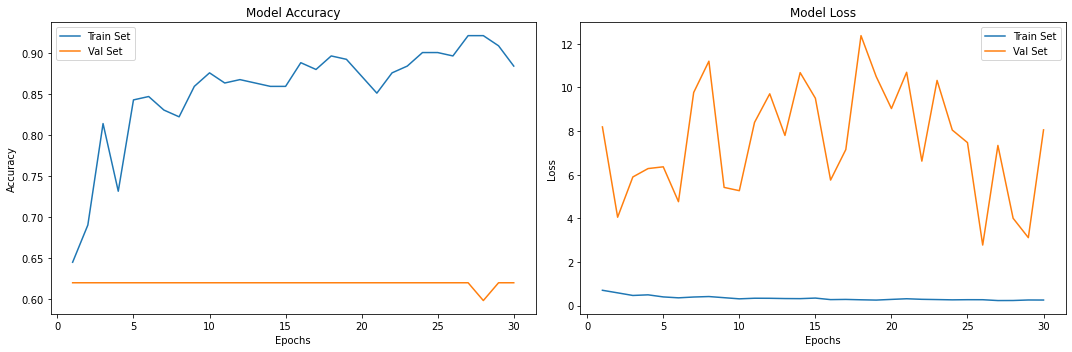

In [83]:
# plot model performance
acc = history_xception.history['accuracy']
val_acc = history_xception.history['val_accuracy']
loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']
epochs_range = range(1, len(history_xception.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [84]:
# validate on test set
predictions = model_xception.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.88
Test Accuracy = 0.47
Val Accuracy = 0.62
Kappa Score = 0.00
ROC Area = 0.50
F1 Score = 0.32


C:\Users\zeyne\anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### MobileNet

In [85]:
# load base model
base_model_mobilenet = MobileNetV2(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

9412608/9406464 [==============================] - 1s 0us/step


In [86]:
NUM_CLASSES = 1

model_mobilenet= Sequential()
model_mobilenet.add(base_model_mobilenet)
model_mobilenet.add(layers.Flatten())
model_mobilenet.add(layers.Dropout(0.5))
model_mobilenet.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_mobilenet.layers[0].trainable = False

model_mobilenet.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_mobilenet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_5 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 62721     
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
EPOCHS = 30
history_mobilenet = model_mobilenet.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 9s 1s/step - loss: 1.0065 - accuracy: 0.6157 - val_loss: 0.4984 - val_accuracy: 0.7065
Epoch 2/30
8/8 [==============================] - 1s 150ms/step - loss: 0.8720 - accuracy: 0.6736 - val_loss: 0.6633 - val_accuracy: 0.7500
Epoch 3/30
8/8 [==============================] - 3s 435ms/step - loss: 0.7446 - accuracy: 0.7149 - val_loss: 0.7085 - val_accuracy: 0.6196
Epoch 4/30
8/8 [==============================] - 4s 444ms/step - loss: 0.6651 - accuracy: 0.7190 - val_loss: 0.4476 - val_accuracy: 0.6739
Epoch 5/30
8/8 [==============================] - 5s 564ms/step - loss: 0.6885 - accuracy: 0.7231 - val_loss: 0.8958 - val_accuracy: 0.5761
Epoch 6/30
8/8 [==============================] - 4s 520ms/step - loss: 0.5822 - accuracy: 0.7521 - val_loss: 0.3978 - val_accuracy: 0.7717
Epoch 7/30
8/8 [==============================] - 6s 729ms/step - loss: 0.5013 - accuracy: 0.7727 - val_loss: 0.6284 - val_accuracy: 0.7500
Epoch 8/30
8/8 [=======

In [ ]:
# plot model performance
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']
epochs_range = range(1, len(history_mobilenet.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()